In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#How does the stan code look like 
print(survivalstan.models.pem_survival_model)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<

In [6]:
#simulate data
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=28,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_28.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


In [7]:
d.head()

,age,sex,rate,true_t,t,event,index,age_centered
0,51,male,0.082085,9.415938,9.415938,True,0,-6.107143
1,62,female,0.049787,6.777501,6.777501,True,1,4.892857
2,49,female,0.049787,4.621227,4.621227,True,2,-8.107143
3,48,male,0.082085,8.246045,8.246045,True,3,-9.107143
4,52,female,0.049787,11.400912,11.400912,True,4,-5.107143


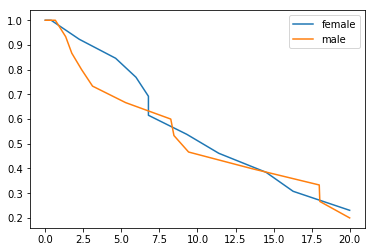

In [9]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [11]:
#transform to long or per time point
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_19273668651.event_col_event.time_col_t.pkl
INFO:stancache.stancache:prep_data_long_surv: Starting execution
INFO:stancache.stancache:prep_data_long_surv: Execution completed (0:00:00.066382 elapsed)
INFO:stancache.stancache:prep_data_long_surv: Saving results to cache


In [12]:
dlong.query('index == 1').sort_values('end_time').tail()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
25,62,female,0.049787,6.777501,6.777501,True,1,4.892857,1,4.621227,False
33,62,female,0.049787,6.777501,6.777501,True,1,4.892857,1,5.276667,False
31,62,female,0.049787,6.777501,6.777501,True,1,4.892857,1,5.959644,False
40,62,female,0.049787,6.777501,6.777501,True,1,4.892857,1,6.776933,False
24,62,female,0.049787,6.777501,6.777501,True,1,4.892857,1,6.777501,True


In [13]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_26_1.model_code_5118842489520038317.pystan_2_17_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40e674354a3ed49066be24f1933b1992 NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:01:06.709791 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_26_1.model_code_5118842489520038317.pystan_2_17_0_0.stanfit.chains_4.data_87012476600.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:02:32.888514 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/home/carlos/anaconda3/

In [15]:
#review of convergence
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

           mean   se_mean         sd       2.5%        50%      97.5%     Rhat
lp__ -65.365796  2.778866  21.344873 -97.968363 -69.286129 -22.694704  1.05022


In [16]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[0]   0.049712  0.002550  0.255003 -0.414558  0.013737  0.688780  1.001339
log_baseline_raw[1]   0.047874  0.002485  0.248527 -0.391459  0.013216  0.667407  1.001809
log_baseline_raw[2]   0.032932  0.002399  0.239898 -0.437580  0.009381  0.623726  1.000782
log_baseline_raw[3]   0.023780  0.002335  0.233514 -0.450275  0.003647  0.572666  1.000169
log_baseline_raw[4]   0.014786  0.002269  0.226926 -0.468205  0.004192  0.530848  0.999739
log_baseline_raw[5]   0.017421  0.002248  0.224764 -0.448265  0.006216  0.540430  0.999796
log_baseline_raw[6]   0.008232  0.002286  0.228623 -0.504877  0.004505  0.526880  1.000015
log_baseline_raw[7]  -0.014135  0.002241  0.224115 -0.549675 -0.004780  0.456625  0.999805
log_baseline_raw[8]  -0.017439  0.002174  0.217384 -0.514228 -0.006532  0.432258  0.999937
log_baseline_raw[9]  -0.019939  0.002261  0.226111 -0.563366 -0.005189  0.442697  1.000403

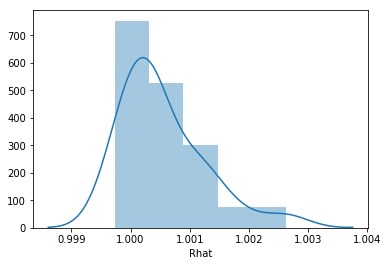

In [18]:
#Rhat values
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

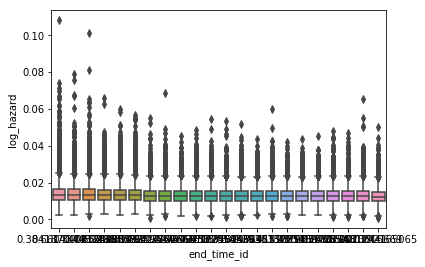

In [20]:
#plot posterior estimates
survivalstan.utils.plot_coefs([testfit], element='baseline')

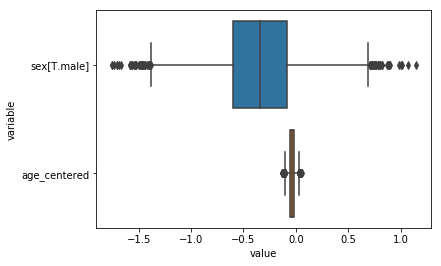

In [21]:
survivalstan.utils.plot_coefs([testfit])

/home/carlos/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


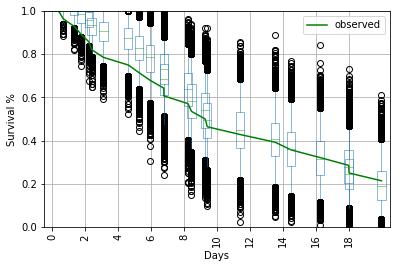

In [22]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()